## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_diagonal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/diagonal/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2006,
 3: 8024,
 4: 32096,
 5: 128384,
 6: 513536,
 7: 2054144,
 8: 8216576,
 9: 32866304}

Running 12760 CDFs


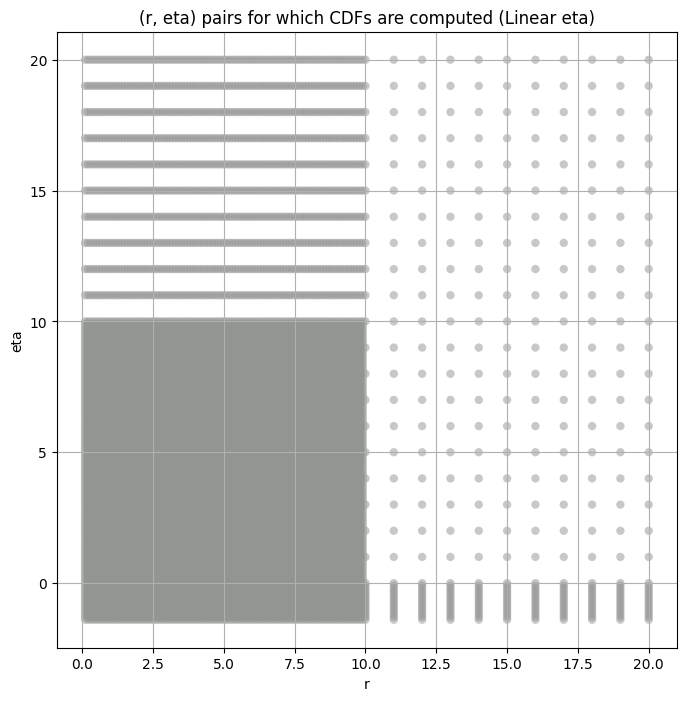

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1372.283000  1206.686200  1549.165200   2.739337    1.776233   
3       306.625950   287.390260   326.495270   2.939897    2.435846   
4        64.093056    59.771650    68.554860   5.134270    4.276410   
5        12.861583    11.860967    13.899074   7.539676    6.285880   
6         2.565435     2.340036     2.807022  10.590967    8.536936   
7         0.574722     0.520719     0.633209  12.501986    9.616921   
8         0.197376     0.179362     0.216648  11.300205    8.657792   
9         0.095006     0.086865     0.103871  10.053569    7.213316   

       kurt_upper  total_samples  
layer                             
2        3.951763         2006.0  
3        3.495969         8024.0  
4        6.163039        32096.0  
5        9.074041       128384.0  
6       13.486422       513536.0  
7       17.318787      2054144.0  
8       15.557276      8216576.0  
9       15.665902     32866304.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      1372.283000    1372.282959     1002.706665      826.100220   
3       306.625950     306.625946      274.271637      253.877808   
4        64.093056      64.093056       60.908989       58.784927   
5        12.861583      12.861583       12.531104       12.296600   
6         2.565435       2.565435        2.480257        2.421344   
7         0.574722       0.574722        0.552066        0.537429   
8         0.197376       0.197376        0.189973        0.185123   
9         0.095006       0.095006        0.091429        0.089189   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2          703.890503       607.395203       467.910828       372.884338   
3          237.610046       223.961395       201.198624       182.489700   
4           56.965473        55.329216        52.502224        50.067154   
5           12.091095        11.906878        11.580825        11.290577   
6            2.371637         2.327265         2.249110         2.180838   
7            0.525229         0.514452         0.495599         0.479288   
8            0.181080         0.177508         0.171259         0.165835   
9            0.087326         0.085687         0.082849         0.080414   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           299.121277       242.682480       194.384811        94.344986  
3           166.554520       152.569595       140.119949       110.757988  
4            47.937428        46.025318        44.289017        39.830677  
5            11.025732        10.781984        10.554339         9.947317  
6             2.119831         2.063830         2.012047         1.875300  
7             0.464744         0.451536         0.439377         0.407683  
8             0.160999         0.156609         0.152580         0.142129  
9             0.078265         0.076332         0.074572         0.070057

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.011076456225701387 1372.283


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.02238075089680369 1002.70667


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.034919911520565505 826.1002


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.047578617484203445 703.8905


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.059434127379669244 607.3952


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.08529343015415769 467.91083


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.10753990816594539 372.88434


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.12932819777680804 299.12128


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.14587117670631408 242.68248


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.16270838396921875 194.38481


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.2252693799866955 94.344986
Number of samples: 2006, Without approximation : 2006.0


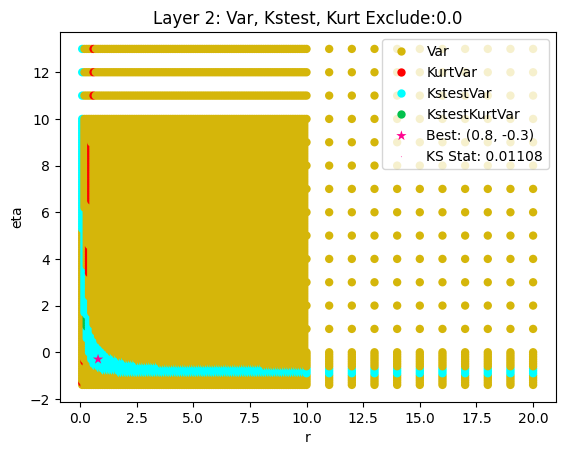

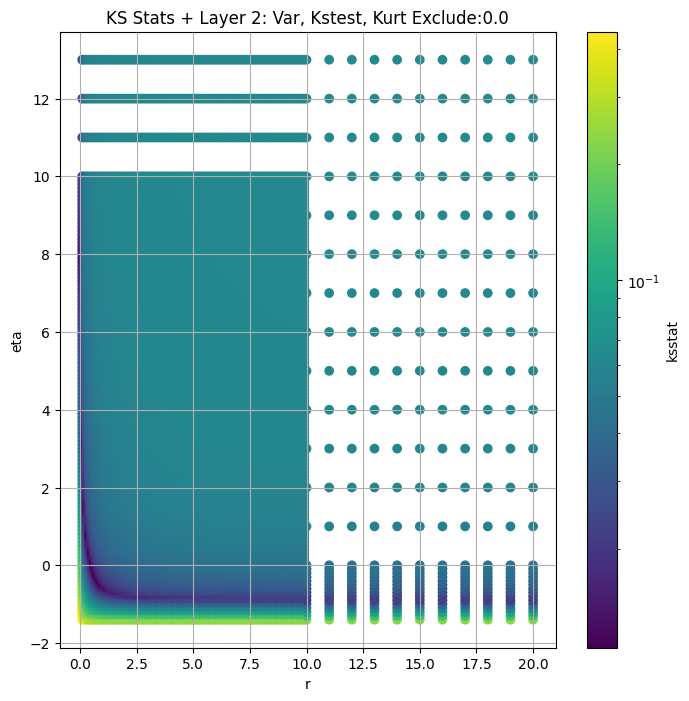

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.013597010615854499 306.62595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.013788878275665328 274.27164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.014625519814721342 253.8778


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.018544014992674066 237.61005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.021940268928779982 223.9614


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.028384716924297324 201.19862


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.03366278766843675 182.4897


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.039528620080661304 166.55452


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.04529932737465123 152.5696


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.051186247299675545 140.11995


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.06896265360383472 110.75799
Number of samples: 8024, Without approximation : 8024.0


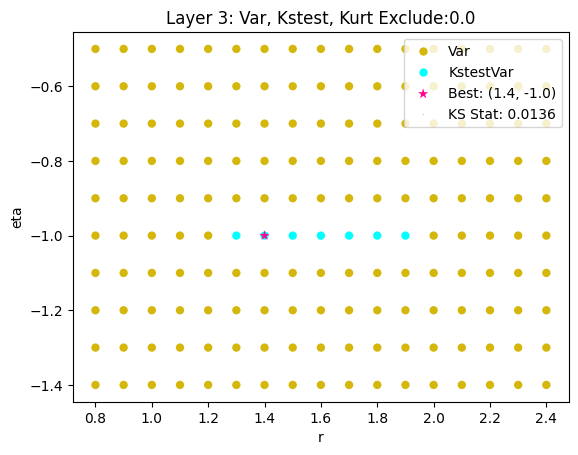

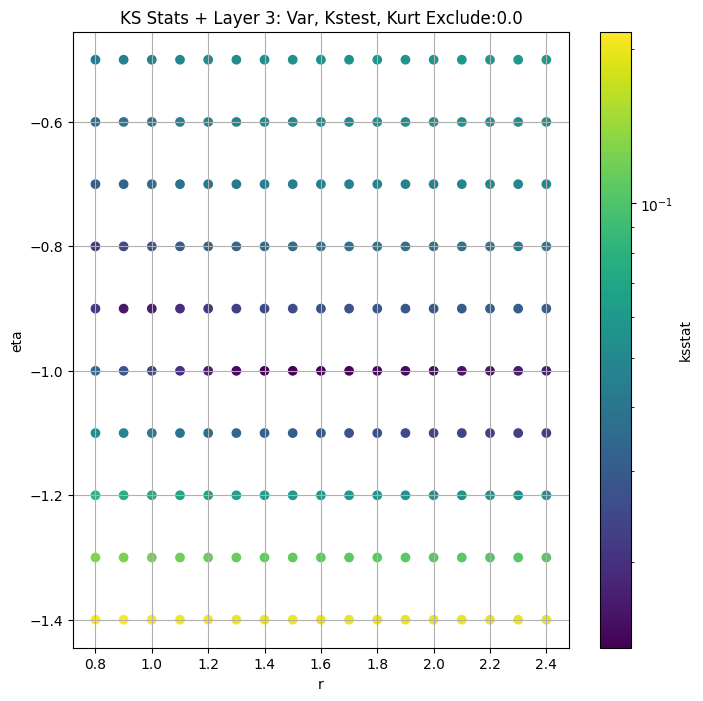

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.020939023154209757 64.093056


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.020938266508045256 60.90899


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.020938531554488327 58.784927


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.020938372376159253 56.965473


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.020938634292309244 55.329216


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.020938438483770694 52.502224


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.020938344171327672 50.067154


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.02093821893809139 47.937428


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.02129590198820208 46.02532


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.021354001827961933 44.289017


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.022521788603448827 39.830677
Number of samples: 32096, Without approximation : 32096.0


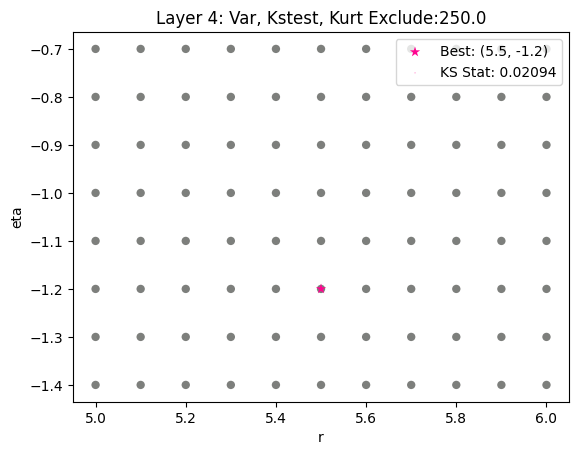

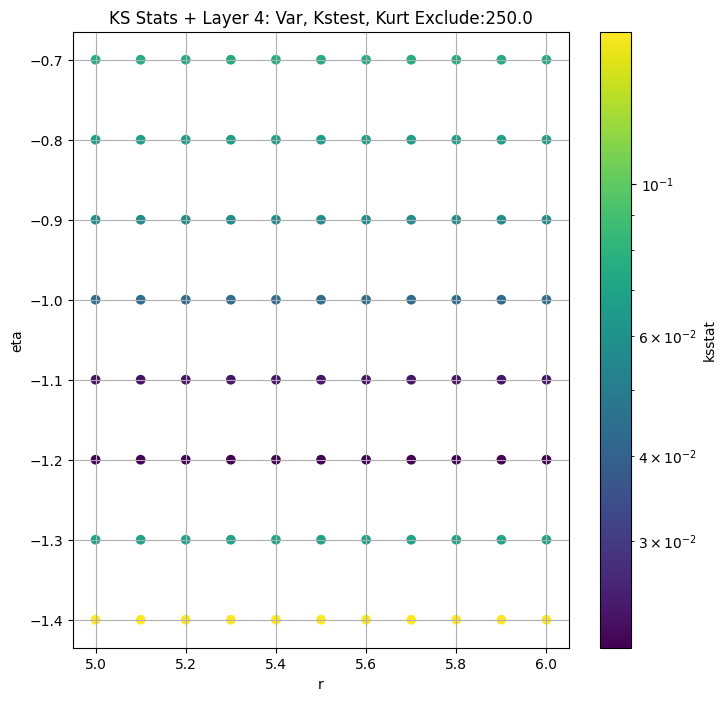

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.04233999999999977 12.861583


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.04233999999999977 12.531104


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.04233999999999977 12.2966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.04233999999999977 12.091095


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.04233999999999977 11.9068775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.04233999999999977 11.580825


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.04233999999999977 11.290577


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.04233999999999977 11.025732


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.04233999999999977 10.781984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.04233999999999977 10.554339


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.04233999999999977 9.947317
Number of samples: 100000, Without approximation : 128384.0


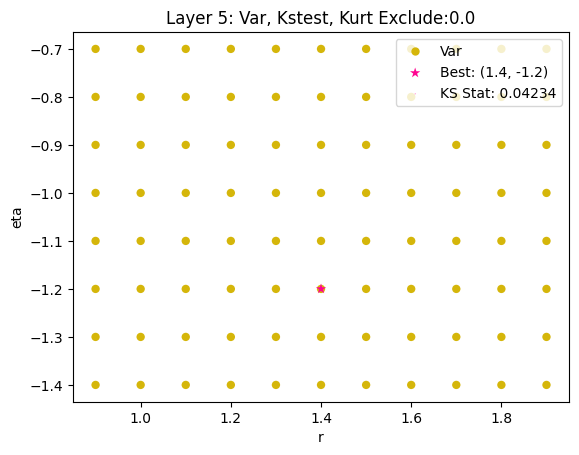

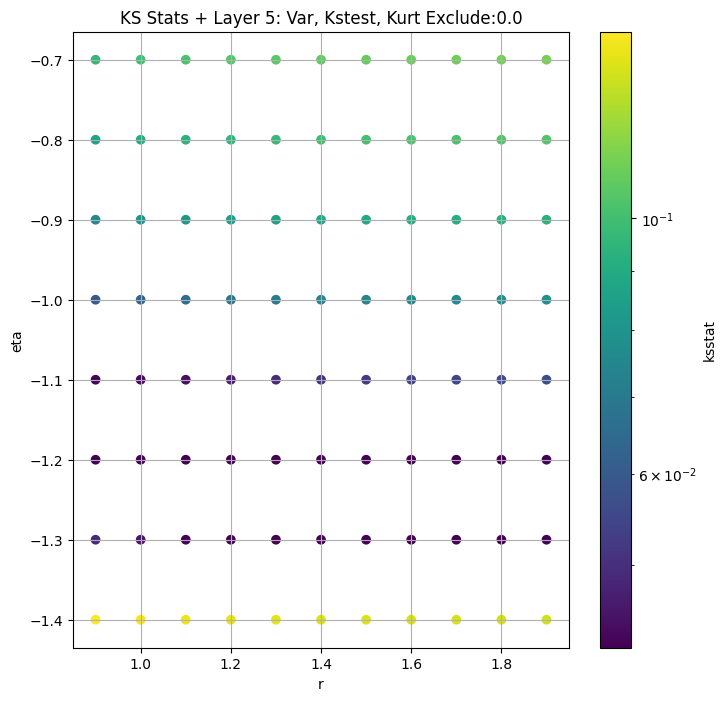

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.07934999999999981 2.565435


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.07934999999999981 2.4802573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.07934999999999981 2.421344


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.07934999999999981 2.3716373


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.07934999999999981 2.3272645


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.07934999999999981 2.2491095


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.07934999999999981 2.1808383


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.07934999999999981 2.119831


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.07934999999999981 2.0638304


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.07934999999999981 2.0120468


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.07934999999999981 1.8752999
Number of samples: 100000, Without approximation : 513536.0


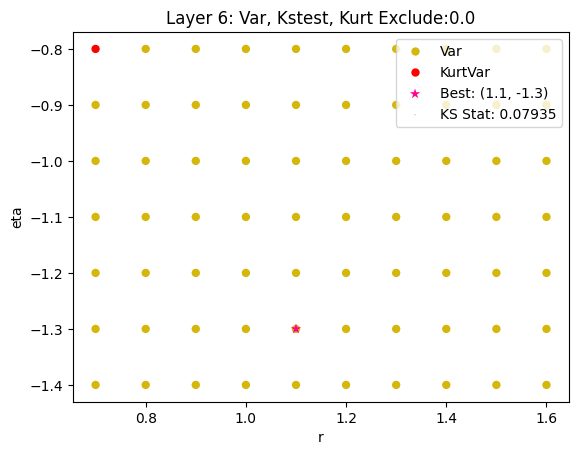

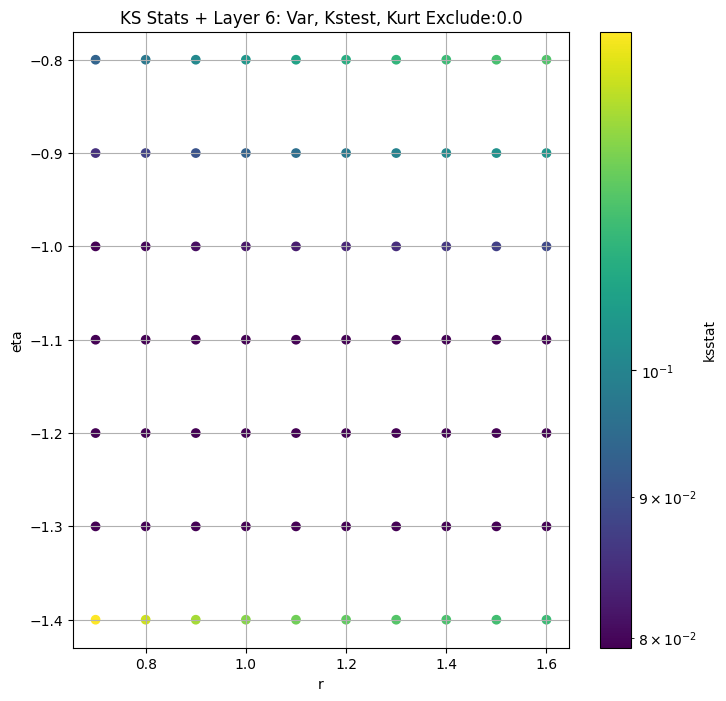

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.12194999999999978 0.5747222


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.12194999999999978 0.5520659


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.12194999999999978 0.5374294


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.12194999999999978 0.5252288


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.12194999999999978 0.51445174


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.12194999999999978 0.49559894


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.12194999999999978 0.47928828


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.12194999999999978 0.464744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.12194999999999978 0.45153567


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.12194999999999978 0.43937653


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.12194999999999978 0.40768293
Number of samples: 100000, Without approximation : 2054144.0


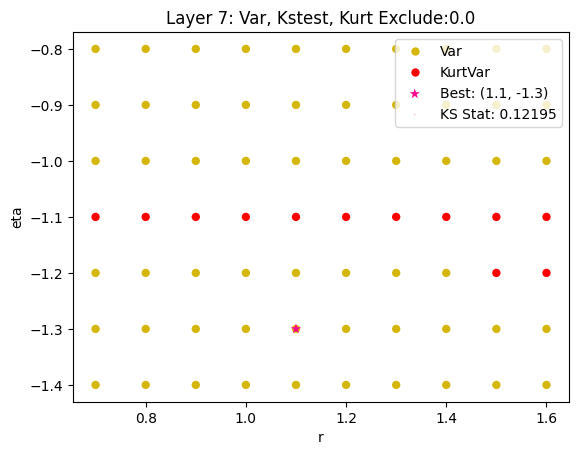

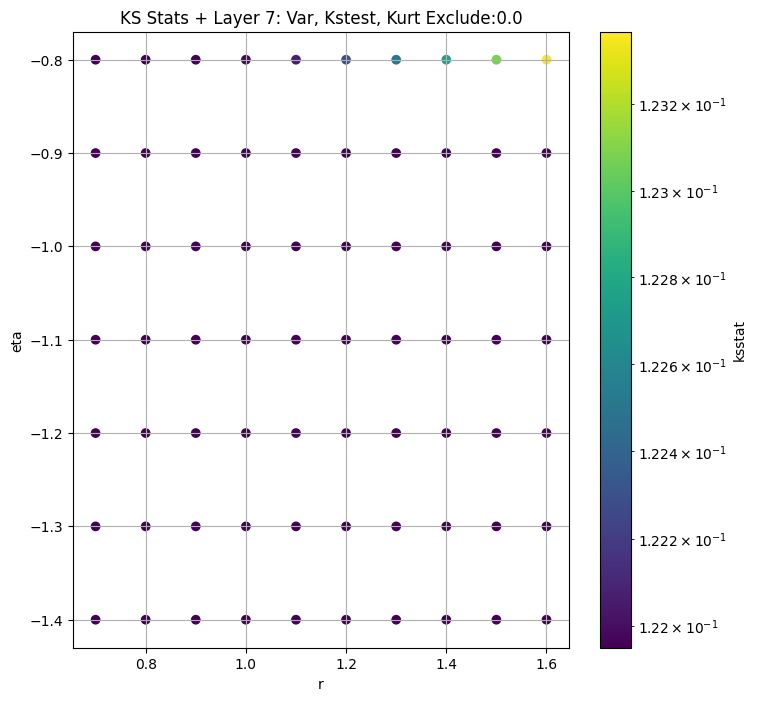

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.1640299999999998 0.19737625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.1640299999999998 0.18997292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.1640299999999998 0.18512319


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.1640299999999998 0.18108033


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.1640299999999998 0.17750841


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.1640299999999998 0.17125882


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.1640299999999998 0.16583483


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.1640299999999998 0.16099893


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.1640299999999998 0.1566091


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.1640299999999998 0.1525799


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.1640299999999998 0.14212887
Number of samples: 100000, Without approximation : 8216576.0


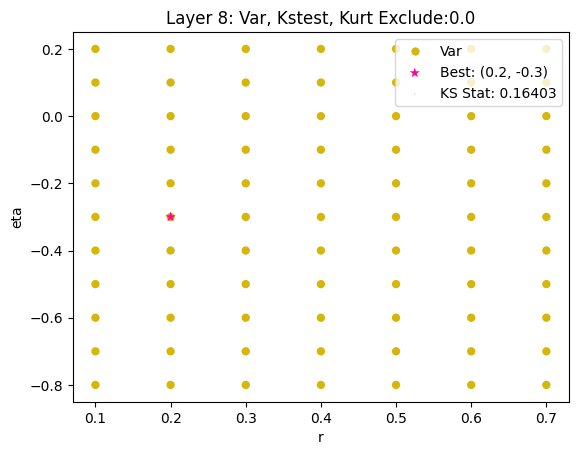

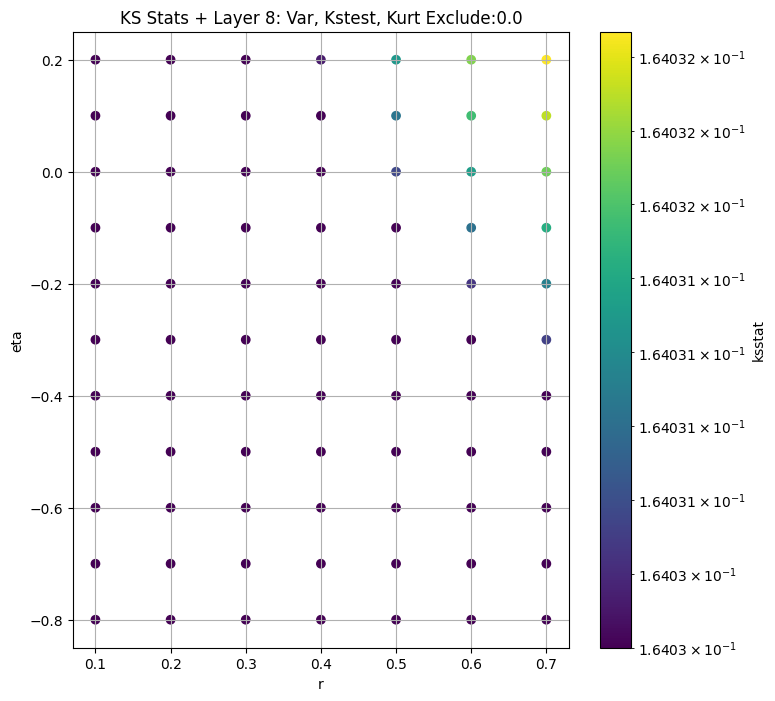

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.2070099999999998 0.09500594


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.2070099999999998 0.0914289


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.2070099999999998 0.08918867


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.2070099999999998 0.0873258


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.2070099999999998 0.08568695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.2070099999999998 0.08284936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.2070099999999998 0.08041426


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.2070099999999998 0.07826456


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.2070099999999998 0.07633214


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.2070099999999998 0.074572034


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.2070099999999998 0.07005727
Number of samples: 100000, Without approximation : 32866304.0


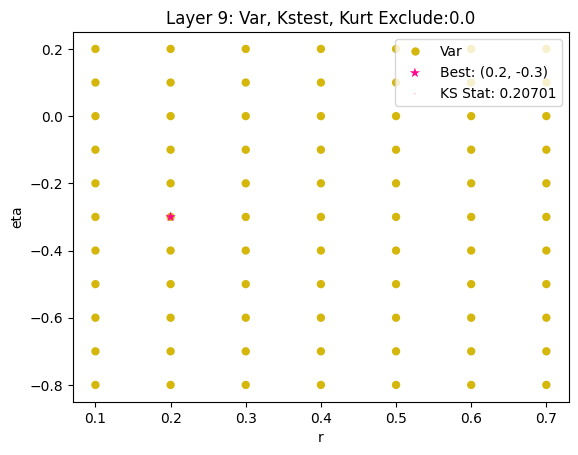

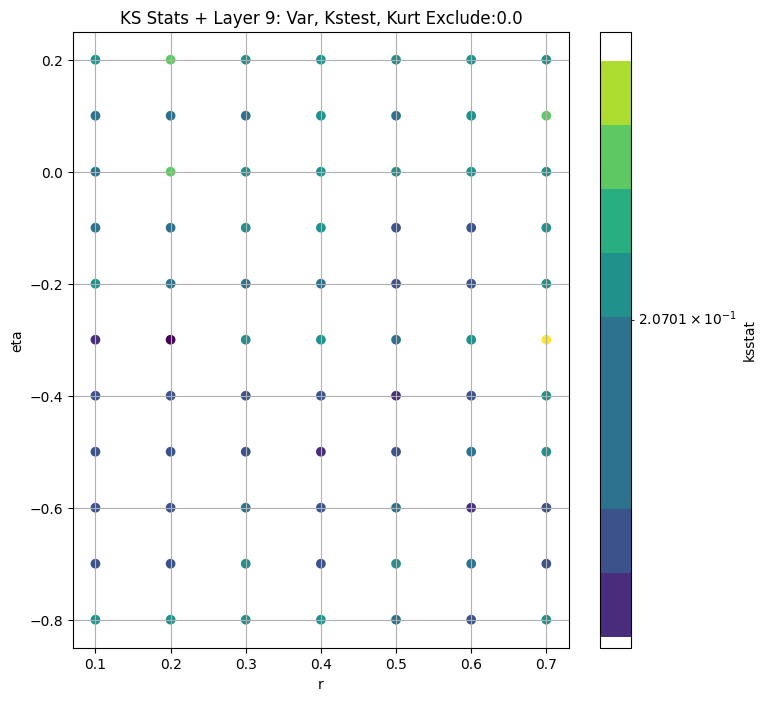

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1372.283000  1206.686200  1549.165200   2.739337    1.776233   
3       306.625950   287.390260   326.495270   2.939897    2.435846   
4        64.093056    59.771650    68.554860   5.134270    4.276410   
5        12.861583    11.860967    13.899074   7.539676    6.285880   
6         2.565435     2.340036     2.807022  10.590967    8.536936   
7         0.574722     0.520719     0.633209  12.501986    9.616921   
8         0.197376     0.179362     0.216648  11.300205    8.657792   
9         0.095006     0.086865     0.103871  10.053569    7.213316   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.951763         2006.0             0.011076        0.8         -0.3   
3        3.495969         8024.0             0.013597        1.4         -1.0   
4        6.163039        32096.0             0.020938        5.5         -1.2   
5        9.074041       128384.0             0.042340        1.4         -1.2   
6       13.486422       513536.0             0.079350        1.1         -1.3   
7       17.318787      2054144.0             0.121950        1.1         -1.3   
8       15.557276      8216576.0             0.164030        0.2         -0.3   
9       15.665902     32866304.0             0.207010        0.2         -0.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2         756.145729                     0.0         1372.283000   
3         793.452378                     0.0          306.625950   
4         221.892213                   250.0           47.937428   
5          52.443468                     0.0           12.861583   
6          13.638940                     0.0            2.565435   
7           3.055467                     0.0            0.574722   
8           0.000007                     0.0            0.197376   
9           0.000003                     0.0            0.095006   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.030238  
3                     0.015140  
4                     0.007575  
5                     0.003789  
6                     0.001895  
7                     0.000947  
8                     0.000474  
9                     0.000237

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.07104723323237461, var: 607.3952026367188


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.056492325058115744, var: 703.8905029296875


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.04095217054735545, var: 826.1002197265625


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.024302769445015415, var: 1002.7066650390625


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.010460482533442228, var: 1372.282958984375
Number of samples: 2006, Without approximation : 2006.0


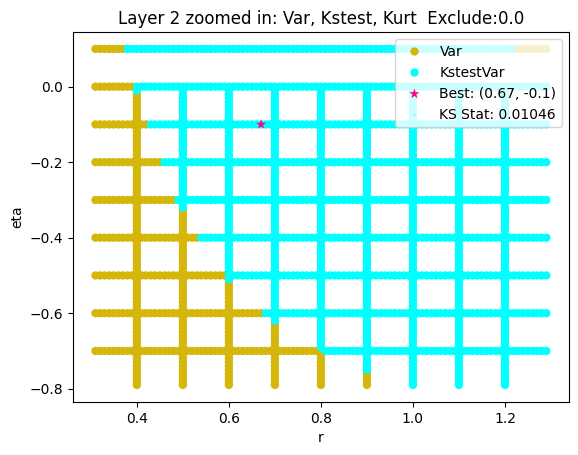

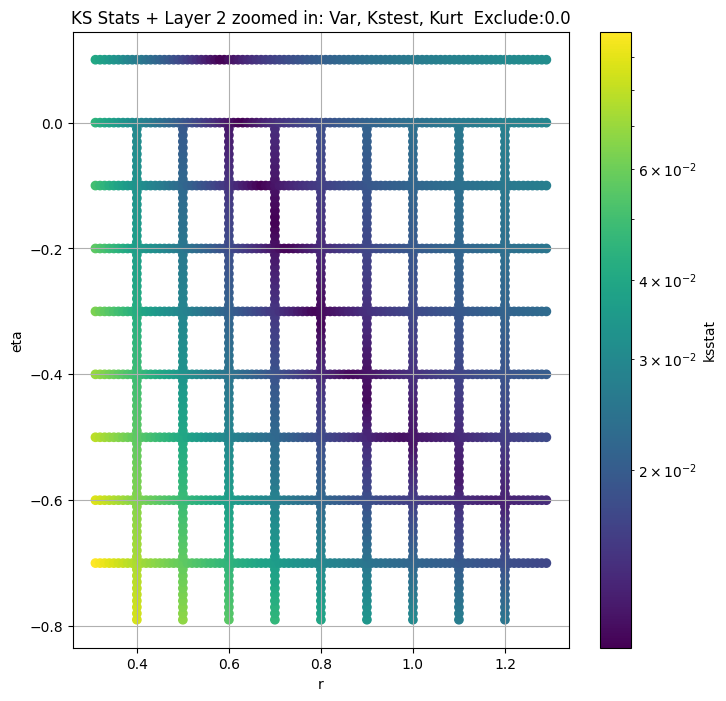

Layer 3


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.024065254577972525, var: 223.96139526367188


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.020833053608349396, var: 237.61004638671875


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.017353481695200693, var: 253.8778076171875


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.01443903888425424, var: 274.2716369628906


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.01272913815502652, var: 306.6259460449219
Number of samples: 8024, Without approximation : 8024.0


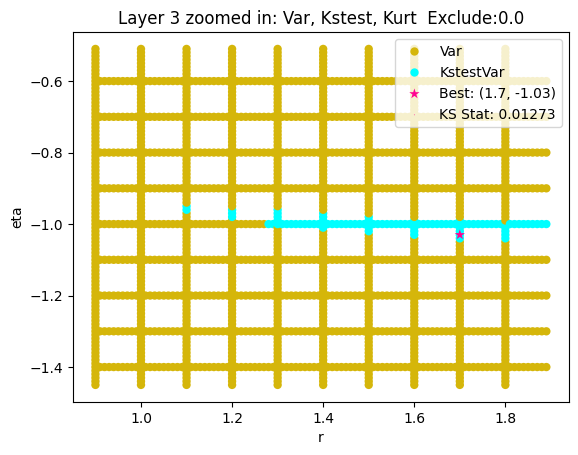

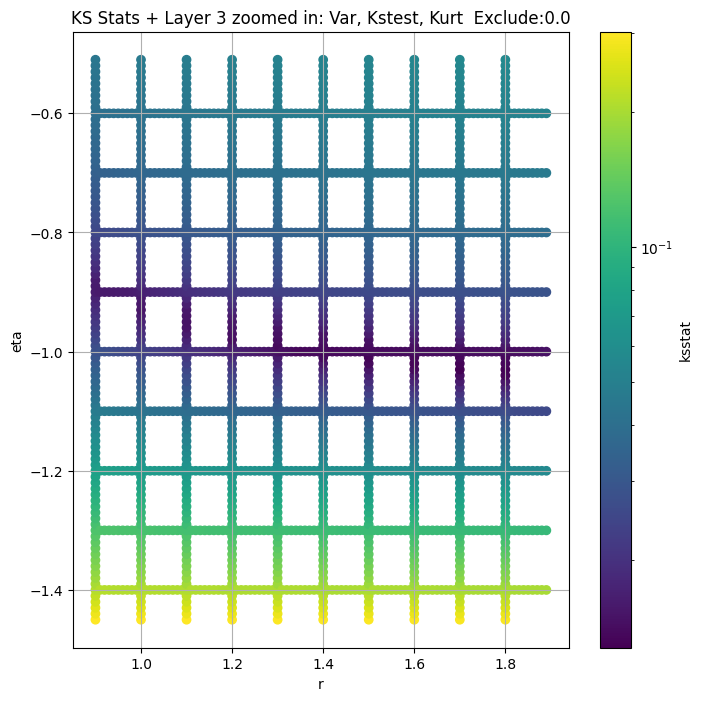

Layer 4


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 4, 250.0 + 100 = 350, ksstat: 0.02260623245599419, var: 44.28901672363281


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 4, 250.0 + 75 = 325, ksstat: 0.022733451516917524, var: 45.132972717285156


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 4, 250.0 + 50 = 300, ksstat: 0.022864517518927596, var: 46.02531814575195


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 4, 250.0 + 25 = 275, ksstat: 0.021875865733993916, var: 46.958106994628906


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 4, 250.0 + 0 = 250, ksstat: 0.02093821893809139, var: 47.93742752075195


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 4, 250.0 + -25 = 225, ksstat: 0.020938490318169023, var: 48.9633903503418


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 4, 250.0 + -50 = 200, ksstat: 0.020938821234007754, var: 50.06715393066406


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 4, 250.0 + -75 = 175, ksstat: 0.020939161622083147, var: 51.241912841796875


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 4, 250.0 + -100 = 150, ksstat: 0.02093951402061517, var: 52.50222396850586
Number of samples: 32096, Without approximation : 32096.0


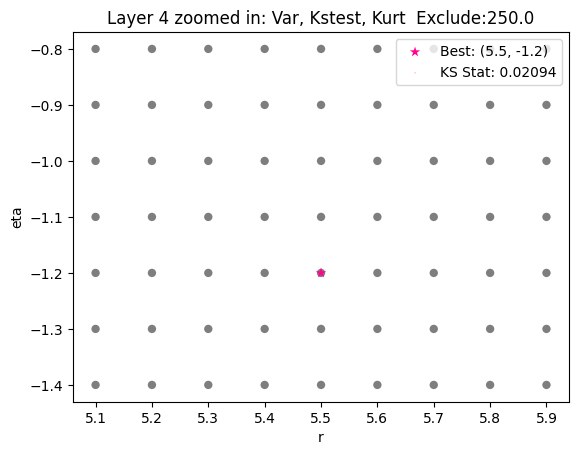

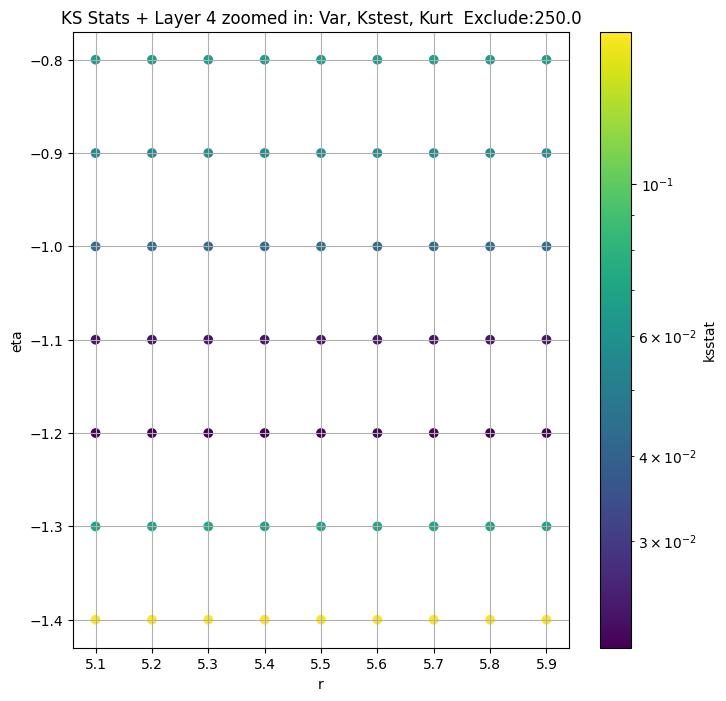

Layer 5


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.04233999999999971, var: 11.906877517700195


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.04233999999999971, var: 12.091094970703125


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.04233999999999971, var: 12.296600341796875


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.04233999999999971, var: 12.53110408782959


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.04233999999999971, var: 12.86158275604248
Number of samples: 100000, Without approximation : 128384.0


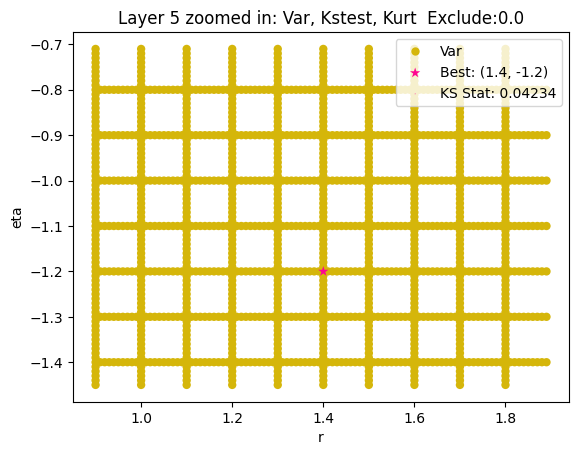

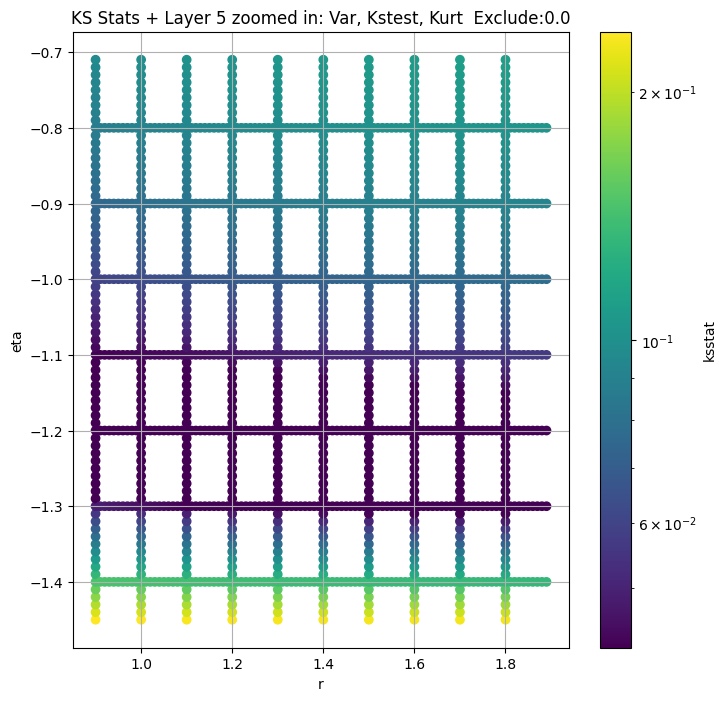

Layer 6


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.07934999999999981, var: 2.3272645473480225


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.07934999999999981, var: 2.3716373443603516


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.07934999999999981, var: 2.421344041824341


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.07934999999999981, var: 2.480257272720337


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.07934999999999981, var: 2.5654349327087402
Number of samples: 100000, Without approximation : 513536.0


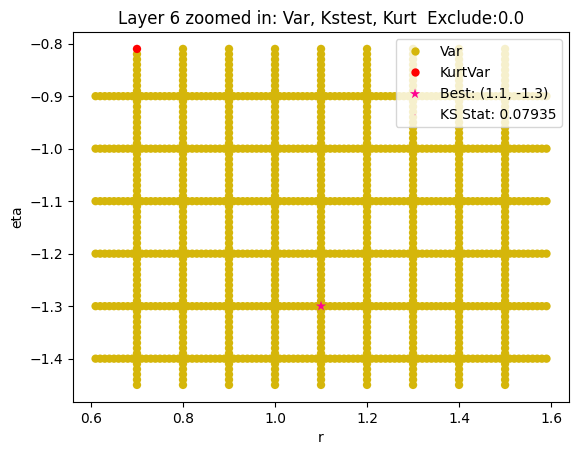

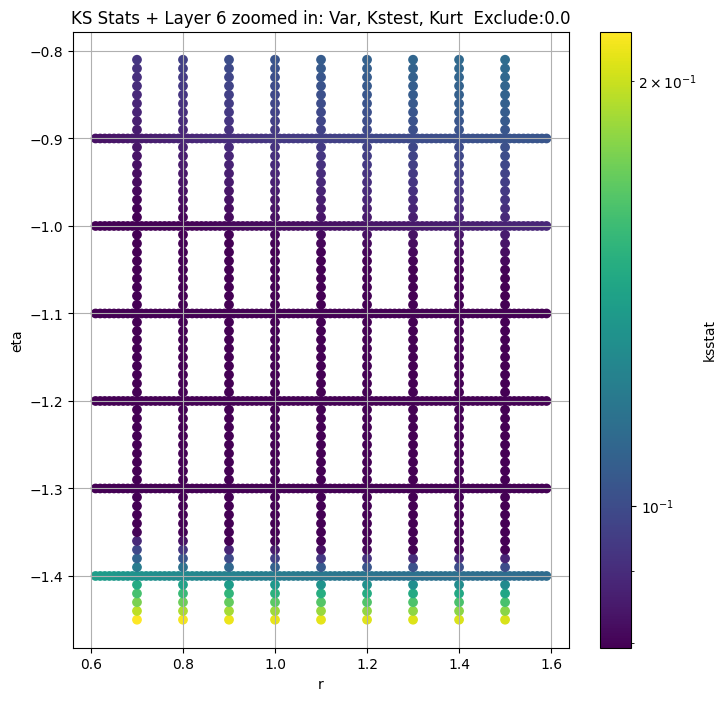

Layer 7


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.12194999999999978, var: 0.5144517421722412


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.12194999999999978, var: 0.5252287983894348


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.12194999999999978, var: 0.5374293923377991


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.12194999999999978, var: 0.552065908908844


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.12194999999999978, var: 0.574722170829773
Number of samples: 100000, Without approximation : 2054144.0


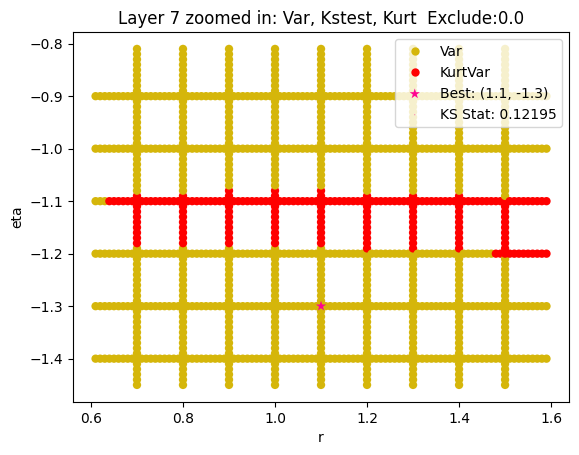

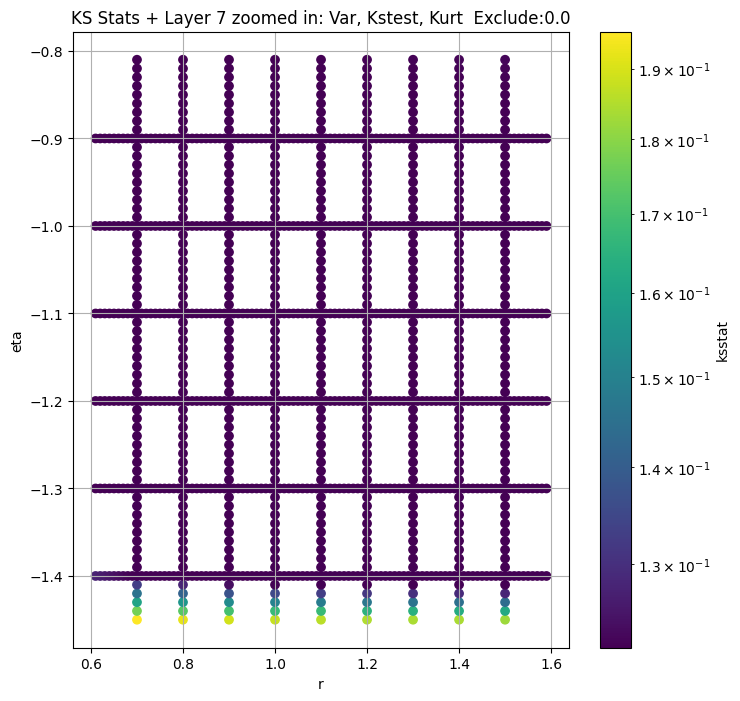

Layer 8


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.1640299999999998, var: 0.1775084137916565


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.1640299999999998, var: 0.18108032643795013


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.1640299999999998, var: 0.18512319028377533


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.1640299999999998, var: 0.189972922205925


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.1640299999999998, var: 0.19737625122070312
Number of samples: 100000, Without approximation : 8216576.0


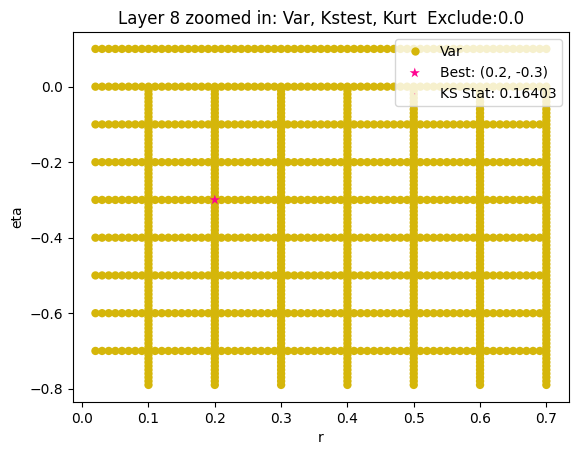

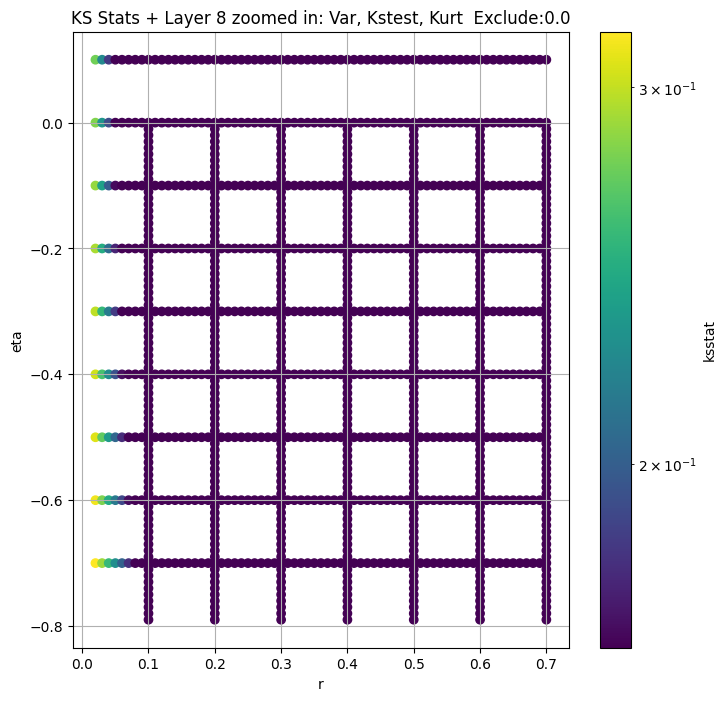

Layer 9


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.2070099999999998, var: 0.08568695187568665


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.2070099999999998, var: 0.0873257964849472


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.2070099999999998, var: 0.08918867260217667


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.2070099999999998, var: 0.09142889827489853


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.2070099999999998, var: 0.09500593692064285
Number of samples: 100000, Without approximation : 32866304.0


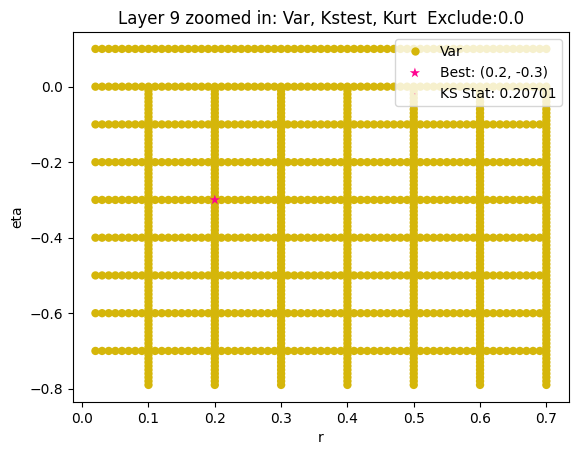

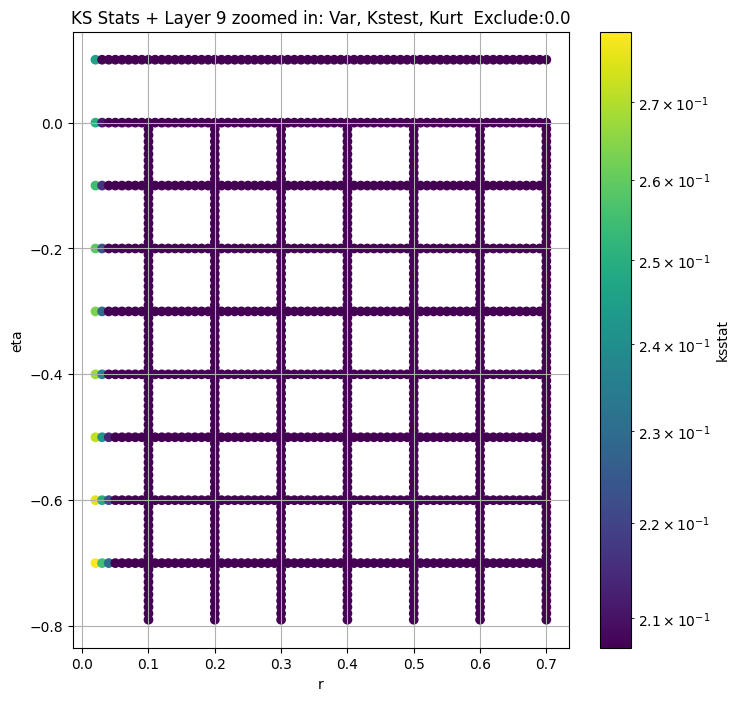

Not a fit


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1372.283000  1206.686200  1549.165200   2.739337    1.776233   
3       306.625950   287.390260   326.495270   2.939897    2.435846   
4        64.093056    59.771650    68.554860   5.134270    4.276410   
5        12.861583    11.860967    13.899074   7.539676    6.285880   
6         2.565435     2.340036     2.807022  10.590967    8.536936   
7         0.574722     0.520719     0.633209  12.501986    9.616921   
8         0.197376     0.179362     0.216648  11.300205    8.657792   
9         0.095006     0.086865     0.103871  10.053569    7.213316   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.951763         2006.0             0.011076        0.8         -0.3   
3        3.495969         8024.0             0.013597        1.4         -1.0   
4        6.163039        32096.0             0.020938        5.5         -1.2   
5        9.074041       128384.0             0.042340        1.4         -1.2   
6       13.486422       513536.0             0.079350        1.1         -1.3   
7       17.318787      2054144.0             0.121950        1.1         -1.3   
8       15.557276      8216576.0             0.164030        0.2         -0.3   
9       15.665902     32866304.0             0.207010        0.2         -0.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2         756.145729                     0.0         1372.282959   
3         793.452378                     0.0          306.625946   
4         221.892213                   250.0           47.937428   
5          52.443468                     0.0           12.861583   
6          13.638940                     0.0            2.565435   
7           3.055467                     0.0            0.574722   
8           0.000007                     0.0            0.197376   
9           0.000003                     0.0            0.095006   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.030238          0.010460    0.67     -0.10   
3                     0.015140          0.012729    1.70     -1.03   
4                     0.007575          0.020938    5.50     -1.20   
5                     0.003789          0.042340    1.40     -1.20   
6                     0.001895          0.079350    1.10     -1.30   
7                     0.000947          0.121950    1.10     -1.30   
8                     0.000474          0.164030    0.20     -0.30   
9                     0.000237          0.207010    0.20     -0.30   

       best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                
2      392.288209                  0.0        17131  
3      909.740986                  0.0        12036  
4      221.892213                250.0         4012  
5       52.443468                  0.0         1003  
6       13.638940                  0.0          280  
7        3.055467                  0.0          125  
8        0.000007                  0.0           69  
9        0.000003                  0.0           -1

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

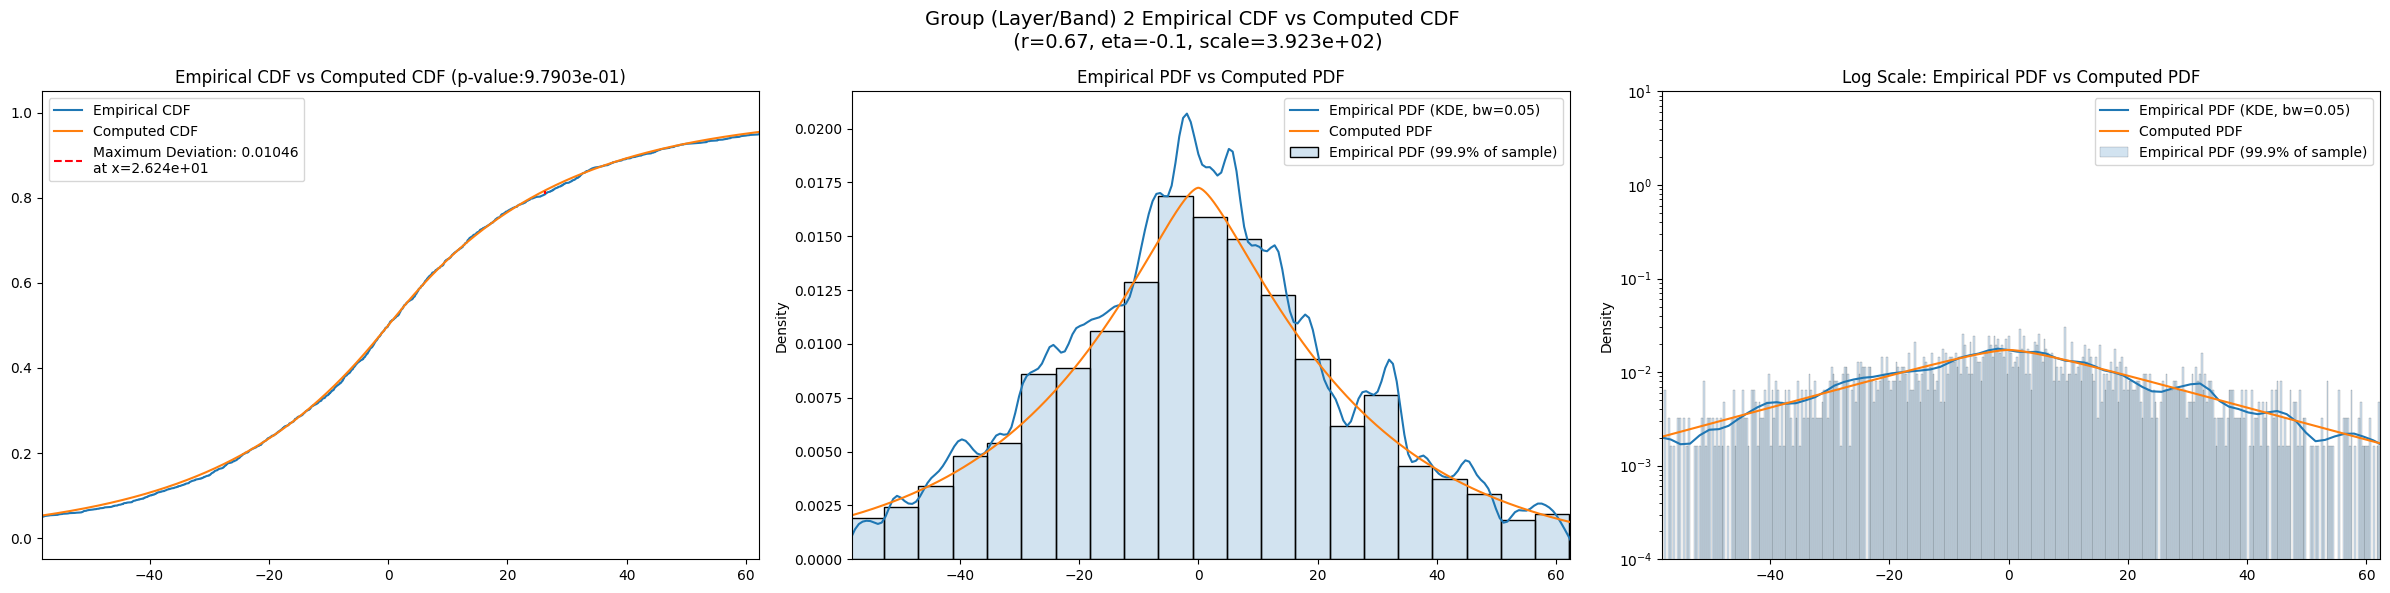

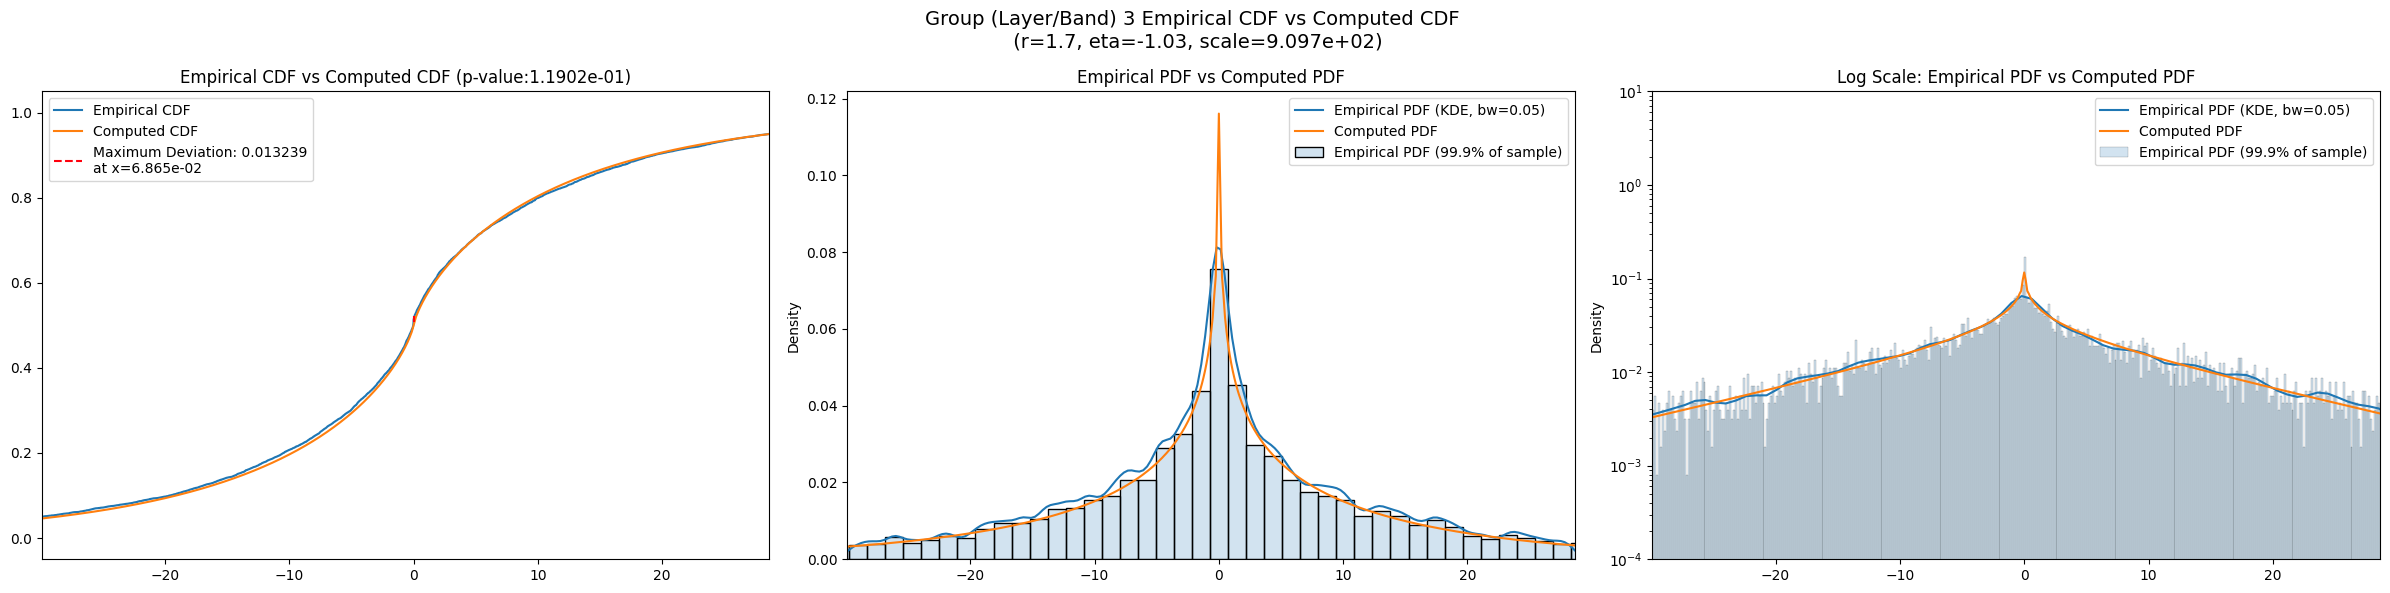

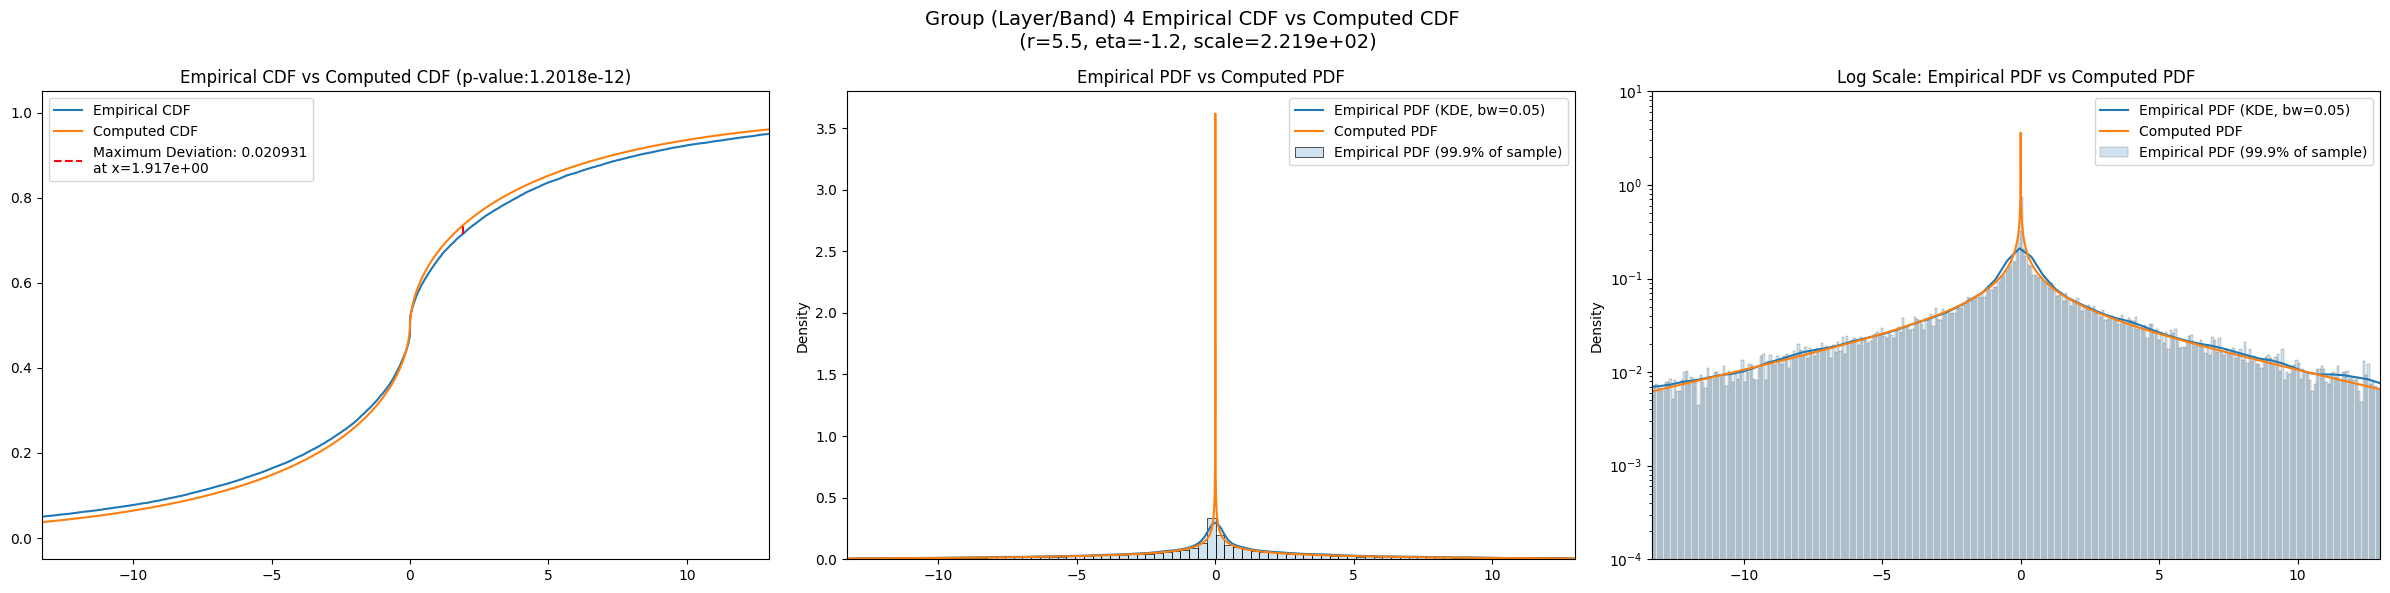

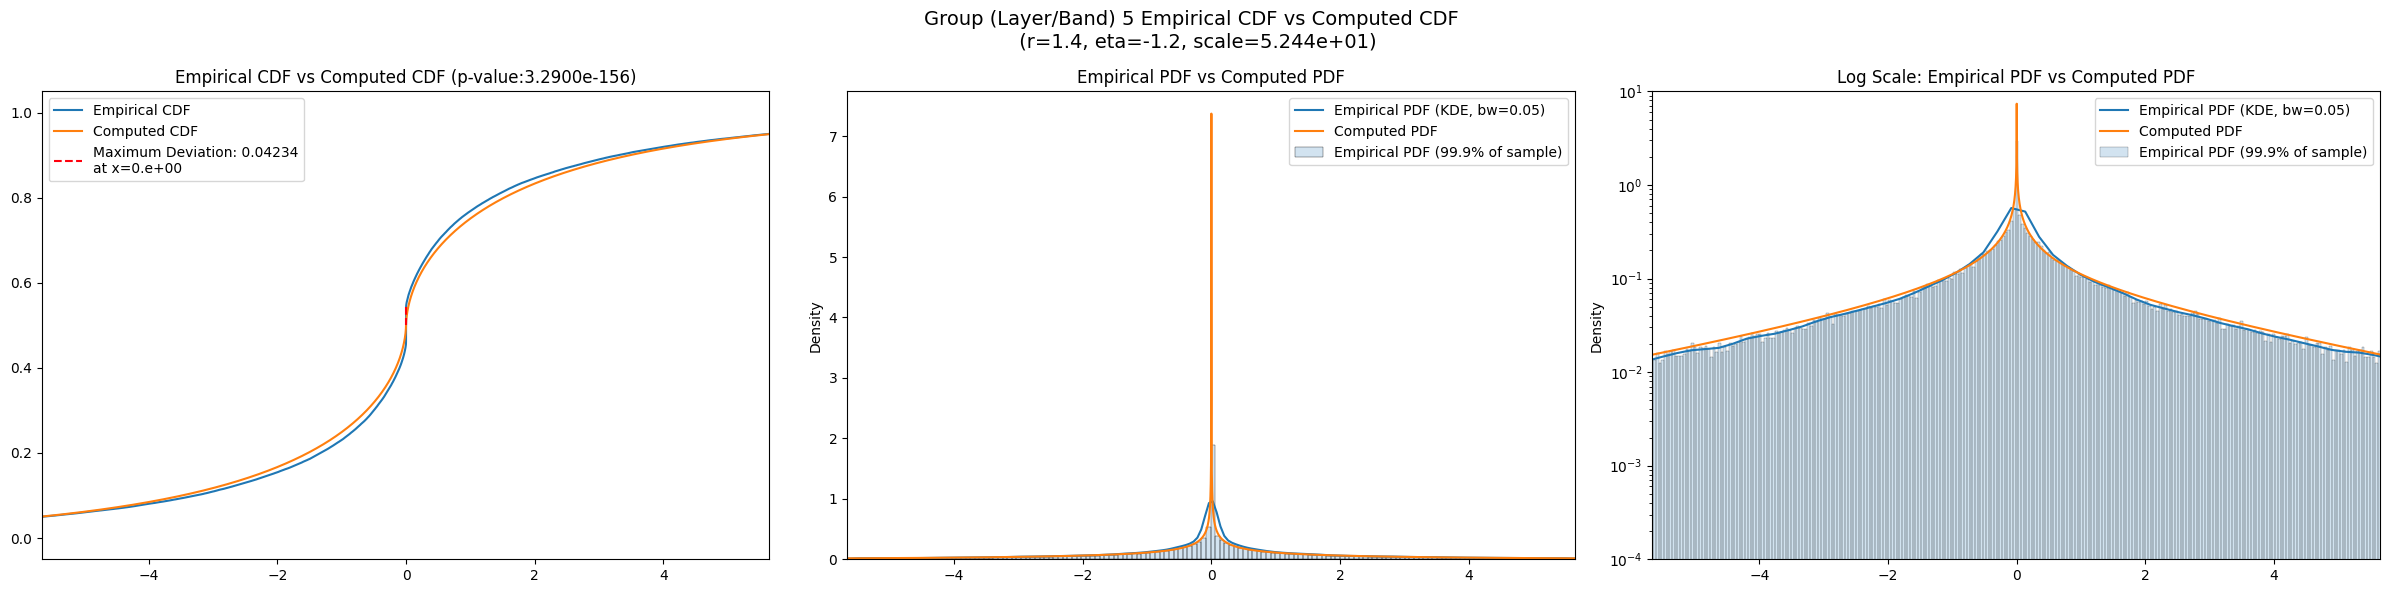

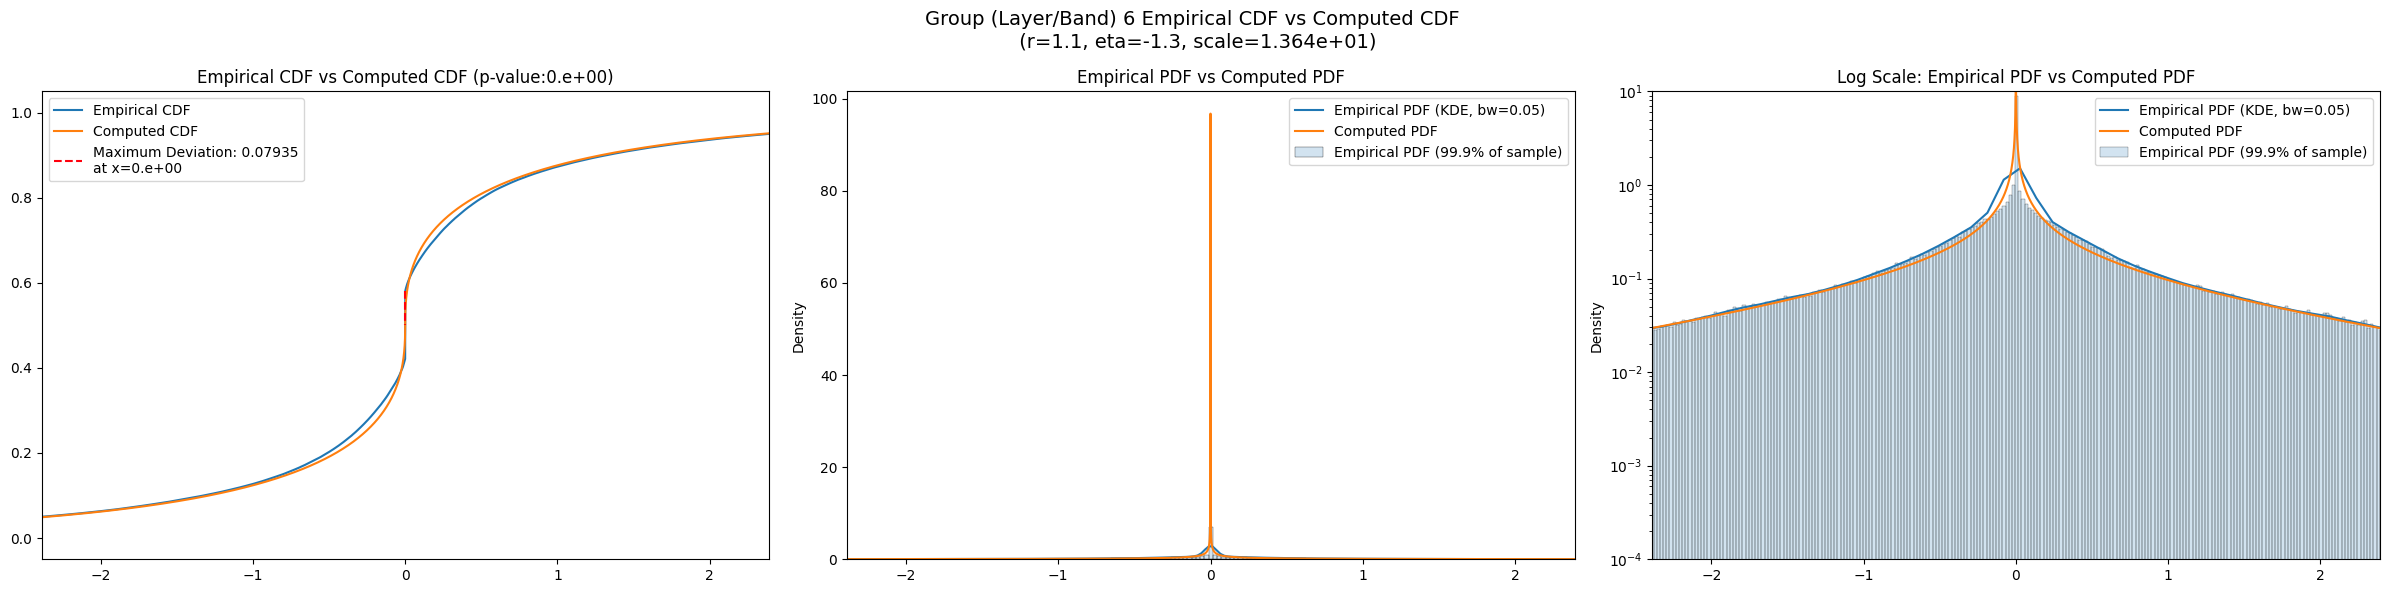

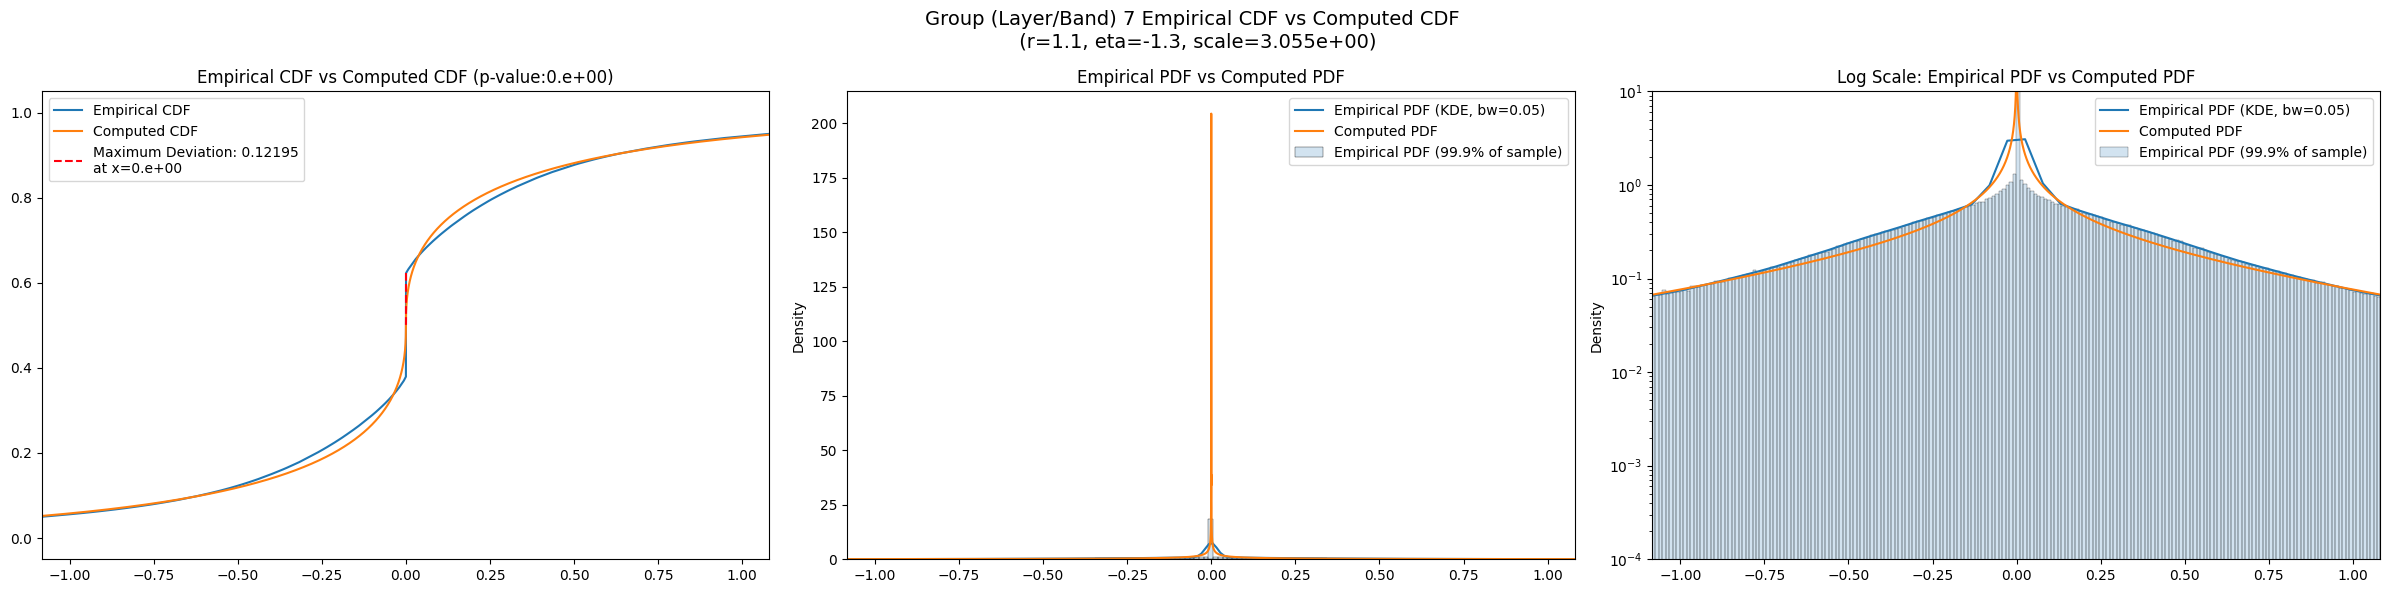

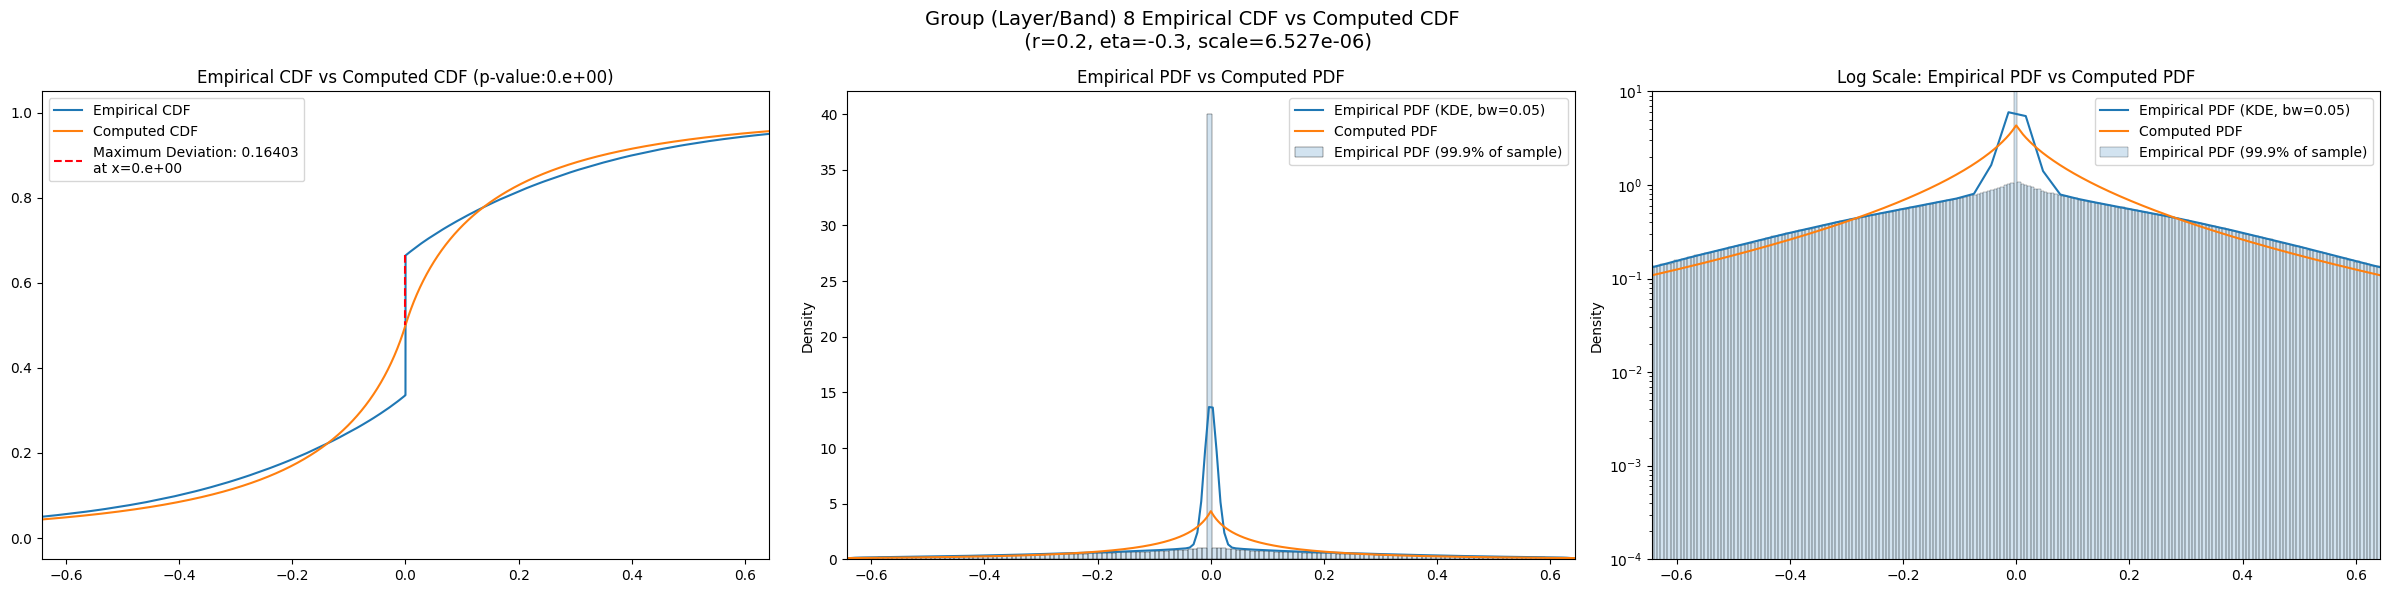

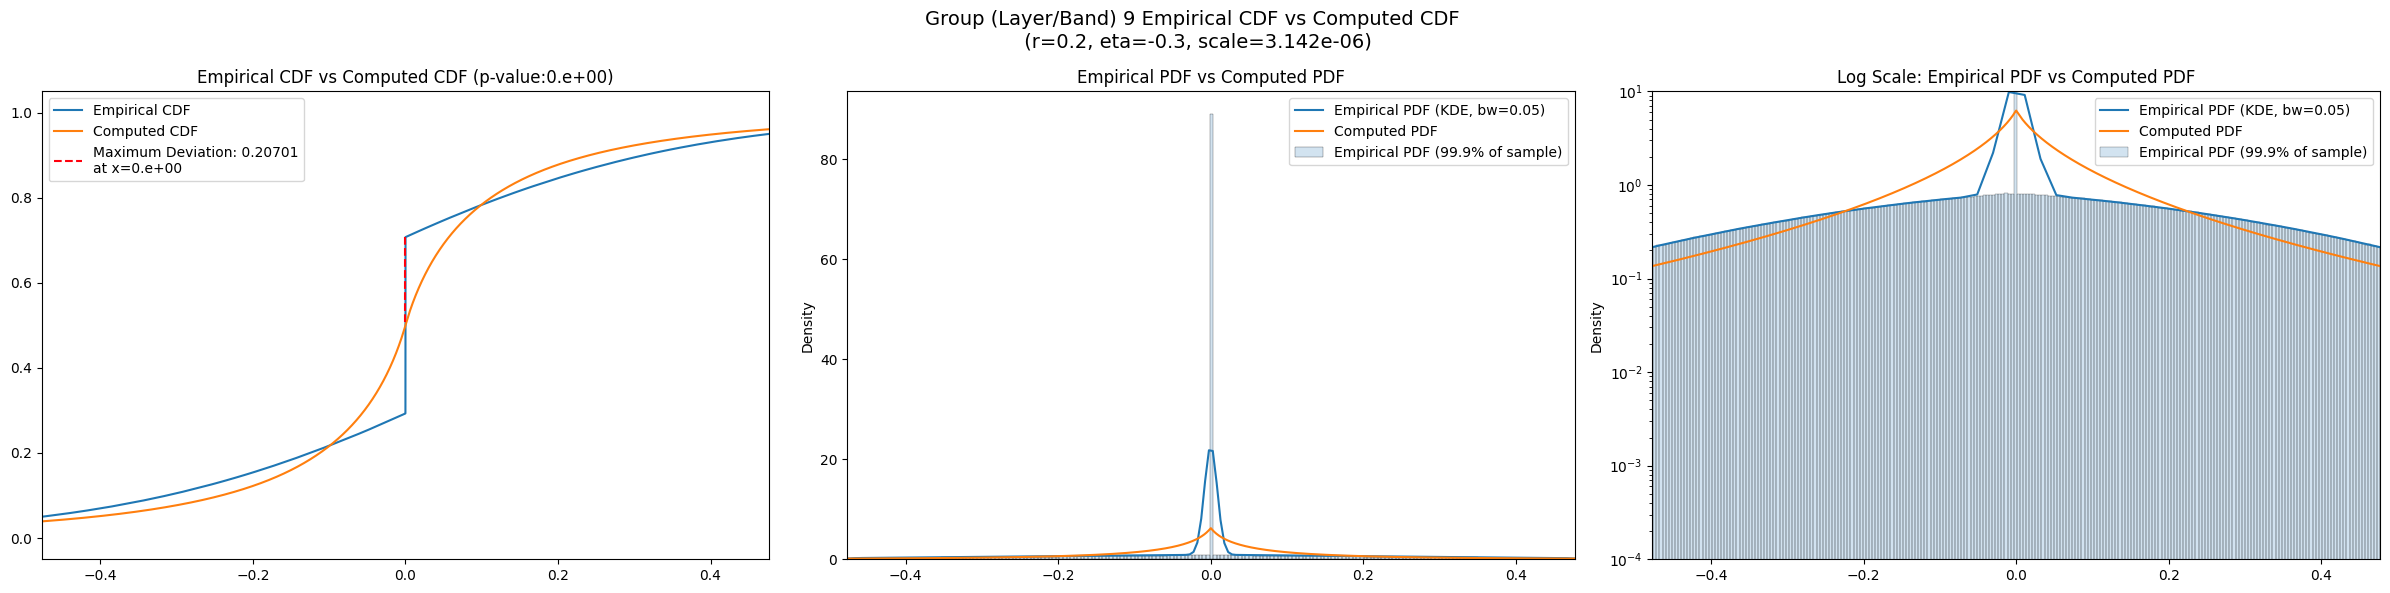

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1372.283000  1206.686200  1549.165200   2.739337    1.776233   
3       306.625950   287.390260   326.495270   2.939897    2.435846   
4        64.093056    59.771650    68.554860   5.134270    4.276410   
5        12.861583    11.860967    13.899074   7.539676    6.285880   
6         2.565435     2.340036     2.807022  10.590967    8.536936   
7         0.574722     0.520719     0.633209  12.501986    9.616921   
8         0.197376     0.179362     0.216648  11.300205    8.657792   
9         0.095006     0.086865     0.103871  10.053569    7.213316   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.951763         2006.0             0.011076        0.8         -0.3   
3        3.495969         8024.0             0.013597        1.4         -1.0   
4        6.163039        32096.0             0.020938        5.5         -1.2   
5        9.074041       128384.0             0.042340        1.4         -1.2   
6       13.486422       513536.0             0.079350        1.1         -1.3   
7       17.318787      2054144.0             0.121950        1.1         -1.3   
8       15.557276      8216576.0             0.164030        0.2         -0.3   
9       15.665902     32866304.0             0.207010        0.2         -0.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       30.193400              0.033336          2.263730e-02   
3      ...       11.919400              0.055143          1.197780e-21   
4      ...        4.346500              0.071837         1.772640e-144   
5      ...        1.573570              0.082605          0.000000e+00   
6      ...        0.571302              0.091961          0.000000e+00   
7      ...        0.236287              0.121950          0.000000e+00   
8      ...        0.139044              0.164030          0.000000e+00   
9      ...        0.332193              0.207010          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          26.108000             0.011345         9.559180e-01  22.271500   
3          10.090200             0.031212         3.169240e-07   8.294890   
4           3.648630             0.048742         1.043880e-66   2.936750   
5           1.282910             0.062387         0.000000e+00   1.007680   
6           0.420509             0.081594         0.000000e+00   0.329973   
7           0.306663             0.121950         0.000000e+00   0.205308   
8           0.205309             0.164030         0.000000e+00   0.126888   
9           0.332193             0.207010         0.000000e+00   0.332183   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.013923   8.262510e-01          9.790274e-01  
3           0.037067   5.149600e-10          1.471898e-01  
4           0.053068   5.309720e-79          1.179757e-12  
5           0.064924   0.000000e+00         2.008614e-200  
6           0.082789   0.000000e+00          0.000000e+00  
7           0.121950   0.000000e+00          0.000000e+00  
8           0.164030   0.000000e+00          0.000000e+00  
9           0.207010   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.011076                 0.030238          0.010460   
3                 0.013597                 0.015140          0.012729   
4                 0.020938                 0.007575          0.020938   
5                 0.042340                 0.003789          0.042340   
6                 0.079350                 0.001895          0.079350   
7                 0.121950                 0.000947          0.121950   
8                 0.164030                 0.000474          0.164030   
9                 0.207010                 0.000237          0.207010   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.033336             0.011345       0.013923  
3                  0.055143             0.031212       0.037067  
4                  0.071837             0.048742       0.053068  
5                  0.082605             0.062387       0.064924  
6                  0.091961             0.081594       0.082789  
7                  0.121950             0.121950       0.121950  
8                  0.164030             0.164030       0.164030  
9                  0.207010             0.207010       0.207010

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta  best_scale  \
layer                                                                       
2             1372.282959          0.010460    0.67     -0.10  392.288209   
3              306.625946          0.012729    1.70     -1.03  909.740986   
4               47.937428          0.020938    5.50     -1.20  221.892213   
5               12.861583          0.042340    1.40     -1.20   52.443468   
6                2.565435          0.079350    1.10     -1.30   13.638940   
7                0.574722          0.121950    1.10     -1.30    3.055467   
8                0.197376          0.164030    0.20     -0.30    0.000007   
9                0.095006          0.207010    0.20     -0.30    0.000003   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                    250.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                      0.0  
9                      0.0

In [21]:
eng.quit()